In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Load and clean data
df = pd.read_csv('../../data/downloads/freight_model_20250423_234035.csv')
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
df.dropna(subset=["total_quantity", "adjusted_freight_price","total_cost"], inplace=True)
df = df[df['adjusted_freight_price'] > 0]

# 📊 Define metrics and visuals
metrics = ["total_quantity"]
titles = ["Total Quantity"]
colors = ["navy", "maroon", "steelblue", "darkorange"]

# 🔁 Loop by commodity group
commodity_groups = df['unique_commodity_group_input'].dropna().unique()

for group in commodity_groups:
    group_df = df[df['unique_commodity_group_input'] == group]

    # 🔁 Sort sites once by market_rate median
    market_sorted = (
        group_df.dropna(subset=["total_quantity", "site"])
        .groupby("site")["total_quantity"]
        .median()
        .sort_values()
        .index.tolist()
    )
    # 🎨 Assign fixed color per site for visual consistency
    site_palette = dict(zip(
    market_sorted,
    sns.color_palette("Set3", n_colors=len(market_sorted))
))

    fig, axes = plt.subplots(2, 2, figsize=(22, 10))
    fig.subplots_adjust(hspace=0.75, wspace=0.3)
    fig.suptitle(f"📦 Distribution and Boxplots for Commodity Group: {group}", fontsize=18, y=1.02)

    for i, metric in enumerate(metrics):
        ax_top = axes[0, i]
        ax_bottom = axes[1, i]
        data = group_df[metric].dropna()

        # 📊 Summary statistics
        q1 = data.quantile(0.25)
        q2 = data.median()
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        group_mean = data.mean()
        group_mode = data.mode().iloc[0] if not data.mode().empty else None

        # 🔢 Fixed or smart zoom per group
        group_str = str(group).strip().replace("[", "").replace("]", "").replace("'", "")
        if group_str == "1VNL":
            x_range = (0, 12500)
        elif group_str == "1CBL":
            x_range = (0, 5000)
        else:
            margin = 5 * iqr
            x_min = max(lower_bound - margin, data.min())
            x_max = min(upper_bound + margin, data.max())
            x_range = (x_min, x_max)

        # 📈 KDEs by site
        for site in group_df['site'].dropna().unique():
            site_subset = group_df[group_df['site'] == site]
            site_subset_valid = site_subset[site_subset[metric].notna()]
            site_data = site_subset_valid[metric]
            unique_invoices = site_subset_valid['invoice_id'].nunique()

            if len(site_data) > 1:
                sns.kdeplot(
    site_data,
    ax=ax_top,
    label=f"{site} (n={unique_invoices})",
    linewidth=1.5,
    color=site_palette.get(site, "gray")
)


        # 🔶 Shade outlier regions
        ax_top.axvspan(x_range[0], lower_bound, color='lightcoral', alpha=0.1, label='Lower Outlier Region')
        ax_top.axvspan(upper_bound, x_range[1], color='lightskyblue', alpha=0.1, label='Upper Outlier Region')

        # 📍 Vertical lines
        ax_top.axvline(group_mean, color='red', linestyle='--', linewidth=2, label='Mean')
        ax_top.axvline(q2, color='purple', linestyle='-', linewidth=2, label='Median')
        ax_top.axvline(q3, color='orange', linestyle=':', linewidth=2, label='Q3')

        # 📝 Summary annotation
        stats_text = (
            f"Mean: {group_mean:.2f} | Median: {q2:.2f} | "
            f"Mode: {group_mode:.2f} | Q1: {q1:.2f} | Q3: {q3:.2f} | "
            f"IQR: {iqr:.2f} | LB: {lower_bound:.2f} | UB: {upper_bound:.2f}"
        )
        ax_top.text(
            0.5, 1.12, stats_text,
            transform=ax_top.transAxes,
            ha='center',
            fontsize=8.5,
            color='black',
            fontweight='bold'
        )

        # 📐 Apply axis range
        ax_top.set_xlim(x_range)
        ax_bottom.set_xlim(x_range)
        ax_top.set_title(f"Distribution of {titles[i]}")
        ax_top.set_xlabel(titles[i])
        ax_top.set_ylabel("Density")
        ax_top.grid(axis='y', visible=False)
        ax_top.grid(axis='x', visible=True)
        ax_top.legend(fontsize="x-small", loc='upper right')

        # 📦 Boxplot + Stripplot (consistent sorting by market_rate)
        plot_data = group_df.dropna(subset=[metric, "site"])
        # 🔁 Build axis labels with (median, mean)
        y_labels = []
        for site in market_sorted:
            site_data = group_df[group_df["site"] == site][metric].dropna()
            if site_data.empty:
                y_labels.append(site)
                continue
            median_val = site_data.median()
            mean_val = site_data.mean()
            label = f"{site} ({mean_val:.2f}, {median_val:.2f})"
            y_labels.append(label)


        sns.boxplot(
            data=plot_data,
            x=metric,
            y="site",
            ax=ax_bottom,
            palette=site_palette,
            fliersize=0,
            order=market_sorted
        )

        sns.stripplot(
            data=plot_data,
            x=metric,
            y="site",
            dodge=True,
            jitter=0.25,
            alpha=0.8,
            size=2,
            
            #palette=site_palette,
            color='black',
            ax=ax_bottom,
            order=market_sorted,
        )
        # ➕ Add mean and median markers per site
        for idx, site in enumerate(market_sorted):
            site_data = plot_data[plot_data["site"] == site][metric]
            if site_data.empty:
                continue
            median_val = site_data.median()
            mean_val = site_data.mean()

            # Horizontal markers: median = purple, mean = red
            ax_bottom.hlines(
                y=idx,
                xmin=median_val - 0.01,
                xmax=median_val + 0.01,
                color='purple',
                linewidth=3,
                label='Median' if idx == 0 else "",  # Only label once for legend
                zorder=5
            )
            ax_bottom.hlines(
                y=idx,
                xmin=mean_val - 0.01,
                xmax=mean_val + 0.01,
                color='red',
                linewidth=3,
                label='Mean' if idx == 0 else "",
                zorder=5
            )


        ax_bottom.set_title(f"Boxplot of {titles[i]} by Site")
        ax_bottom.set_xlabel(titles[i])
        ax_bottom.set_ylabel("Site")
        ax_bottom.legend([], [], frameon=False)

        # 🏷️ Set annotated Y-axis labels
        ax_bottom.set_yticks(range(len(y_labels)))
        ax_bottom.set_yticklabels(y_labels)

    plt.tight_layout()
    plt.show()


KeyError: ['total_quantity', 'adjusted_freight_price', 'total_cost']

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


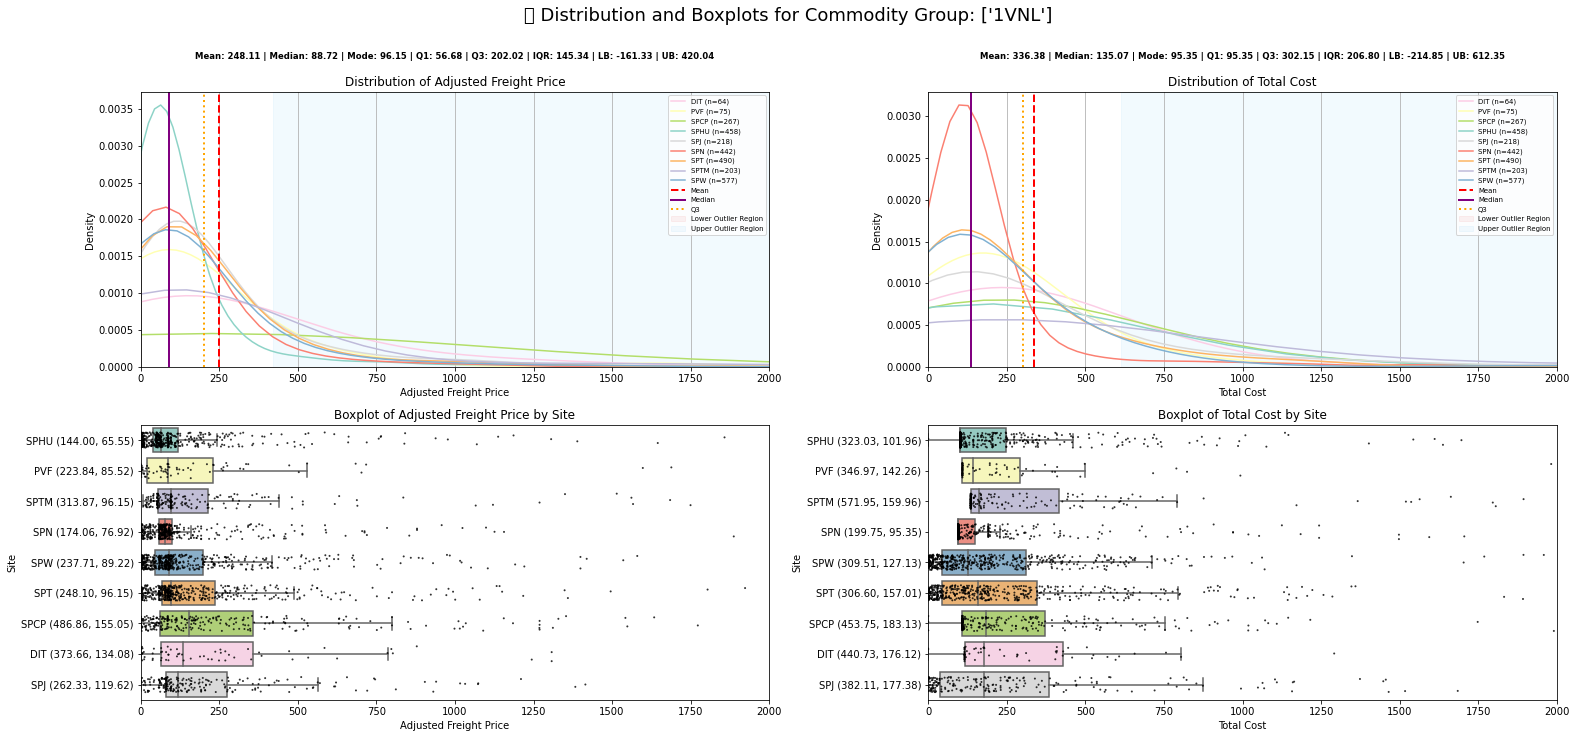

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


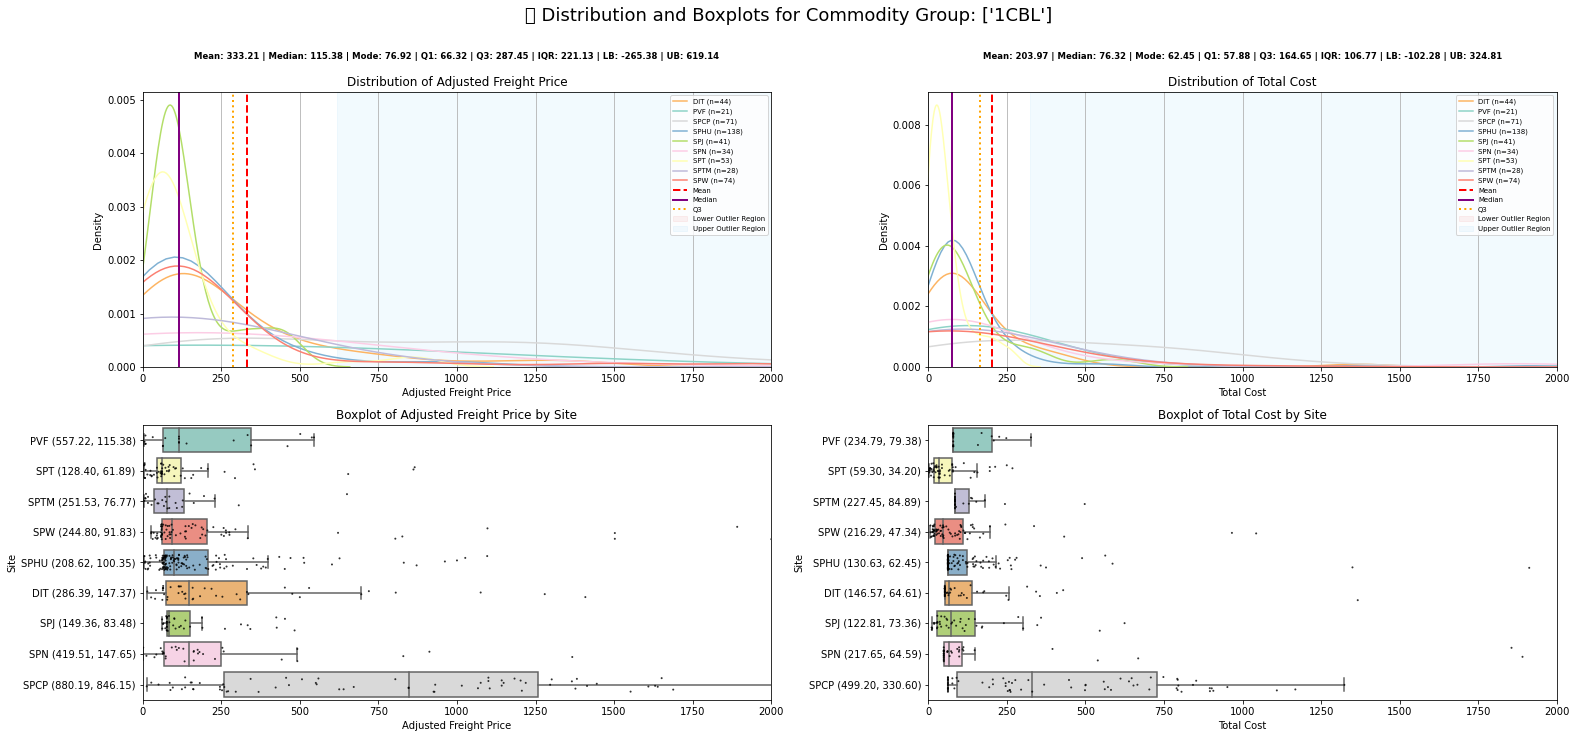

In [47]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Load and clean data
df = pd.read_csv('../../data/downloads/freight_comparison_20250422_182630.csv')
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
df.dropna(subset=["total_quantity", "adjusted_freight_price","total_cost"], inplace=True)
df = df[df['adjusted_freight_price'] > 0]

# 📊 Define metrics and visuals
metrics = ["adjusted_freight_price","total_cost"]
titles = ["Adjusted Freight Price", "Total Cost"]
colors = ["navy", "maroon", "steelblue", "darkorange"]

# 🔁 Loop by commodity group
commodity_groups = df['unique_commodity_group_input'].dropna().unique()

for group in commodity_groups:
    group_df = df[df['unique_commodity_group_input'] == group]

    # 🔁 Sort sites once by market_rate median
    market_sorted = (
        group_df.dropna(subset=["total_quantity", "site"])
        .groupby("site")["total_quantity"]
        .median()
        .sort_values()
        .index.tolist()
    )
    # 🎨 Assign fixed color per site for visual consistency
    site_palette = dict(zip(
    market_sorted,
    sns.color_palette("Set3", n_colors=len(market_sorted))
))

    fig, axes = plt.subplots(2, 2, figsize=(22, 10))
    fig.subplots_adjust(hspace=0.75, wspace=0.3)
    fig.suptitle(f"📦 Distribution and Boxplots for Commodity Group: {group}", fontsize=18, y=1.02)

    for i, metric in enumerate(metrics):
        ax_top = axes[0, i]
        ax_bottom = axes[1, i]
        data = group_df[metric].dropna()

        # 📊 Summary statistics
        q1 = data.quantile(0.25)
        q2 = data.median()
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        group_mean = data.mean()
        group_mode = data.mode().iloc[0] if not data.mode().empty else None

        # 🔢 Fixed or smart zoom per group
        group_str = str(group).strip().replace("[", "").replace("]", "").replace("'", "")
        if group_str == "1VNL":
            x_range = (0, 2000)
        elif group_str == "1CBL":
            x_range = (0, 2000)
        else:
            margin = 5 * iqr
            x_min = max(lower_bound - margin, data.min())
            x_max = min(upper_bound + margin, data.max())
            x_range = (x_min, x_max)

        # 📈 KDEs by site
        for site in group_df['site'].dropna().unique():
            site_subset = group_df[group_df['site'] == site]
            site_subset_valid = site_subset[site_subset[metric].notna()]
            site_data = site_subset_valid[metric]
            unique_invoices = site_subset_valid['invoice_id'].nunique()

            if len(site_data) > 1:
                sns.kdeplot(
    site_data,
    ax=ax_top,
    label=f"{site} (n={unique_invoices})",
    linewidth=1.5,
    color=site_palette.get(site, "gray")
)


        # 🔶 Shade outlier regions
        ax_top.axvspan(x_range[0], lower_bound, color='lightcoral', alpha=0.1, label='Lower Outlier Region')
        ax_top.axvspan(upper_bound, x_range[1], color='lightskyblue', alpha=0.1, label='Upper Outlier Region')

        # 📍 Vertical lines
        ax_top.axvline(group_mean, color='red', linestyle='--', linewidth=2, label='Mean')
        ax_top.axvline(q2, color='purple', linestyle='-', linewidth=2, label='Median')
        ax_top.axvline(q3, color='orange', linestyle=':', linewidth=2, label='Q3')

        # 📝 Summary annotation
        stats_text = (
            f"Mean: {group_mean:.2f} | Median: {q2:.2f} | "
            f"Mode: {group_mode:.2f} | Q1: {q1:.2f} | Q3: {q3:.2f} | "
            f"IQR: {iqr:.2f} | LB: {lower_bound:.2f} | UB: {upper_bound:.2f}"
        )
        ax_top.text(
            0.5, 1.12, stats_text,
            transform=ax_top.transAxes,
            ha='center',
            fontsize=8.5,
            color='black',
            fontweight='bold'
        )

        # 📐 Apply axis range
        ax_top.set_xlim(x_range)
        ax_bottom.set_xlim(x_range)
        ax_top.set_title(f"Distribution of {titles[i]}")
        ax_top.set_xlabel(titles[i])
        ax_top.set_ylabel("Density")
        ax_top.grid(axis='y', visible=False)
        ax_top.grid(axis='x', visible=True)
        ax_top.legend(fontsize="x-small", loc='upper right')

        # 📦 Boxplot + Stripplot (consistent sorting by market_rate)
        plot_data = group_df.dropna(subset=[metric, "site"])
        # 🔁 Build axis labels with (median, mean)
        y_labels = []
        for site in market_sorted:
            site_data = group_df[group_df["site"] == site][metric].dropna()
            if site_data.empty:
                y_labels.append(site)
                continue
            median_val = site_data.median()
            mean_val = site_data.mean()
            label = f"{site} ({mean_val:.2f}, {median_val:.2f})"
            y_labels.append(label)


        sns.boxplot(
            data=plot_data,
            x=metric,
            y="site",
            ax=ax_bottom,
            palette=site_palette,
            fliersize=0,
            order=market_sorted
        )

        sns.stripplot(
            data=plot_data,
            x=metric,
            y="site",
            dodge=True,
            jitter=0.25,
            alpha=0.8,
            size=2,
            
            #palette=site_palette,
            color='black',
            ax=ax_bottom,
            order=market_sorted,
        )
        # ➕ Add mean and median markers per site
        for idx, site in enumerate(market_sorted):
            site_data = plot_data[plot_data["site"] == site][metric]
            if site_data.empty:
                continue
            median_val = site_data.median()
            mean_val = site_data.mean()

            # Horizontal markers: median = purple, mean = red
            ax_bottom.hlines(
                y=idx,
                xmin=median_val - 0.01,
                xmax=median_val + 0.01,
                color='purple',
                linewidth=3,
                label='Median' if idx == 0 else "",  # Only label once for legend
                zorder=5
            )
            ax_bottom.hlines(
                y=idx,
                xmin=mean_val - 0.01,
                xmax=mean_val + 0.01,
                color='red',
                linewidth=3,
                label='Mean' if idx == 0 else "",
                zorder=5
            )


        ax_bottom.set_title(f"Boxplot of {titles[i]} by Site")
        ax_bottom.set_xlabel(titles[i])
        ax_bottom.set_ylabel("Site")
        ax_bottom.legend([], [], frameon=False)

        # 🏷️ Set annotated Y-axis labels
        ax_bottom.set_yticks(range(len(y_labels)))
        ax_bottom.set_yticklabels(y_labels)

    plt.tight_layout()
    plt.show()
